Shape dataset: (6, 5) (2, 5) (2, 5)

=== Eksperimen 1 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Confusion Matrix:
[[1 0]
 [0 1]]
Classification Report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         1
           1      1.000     1.000     1.000         1

    accuracy                          1.000         2
   macro avg      1.000     1.000     1.000         2
weighted avg      1.000     1.000     1.000         2

F1 Score (macro): 1.0
ROC-AUC: 1.0


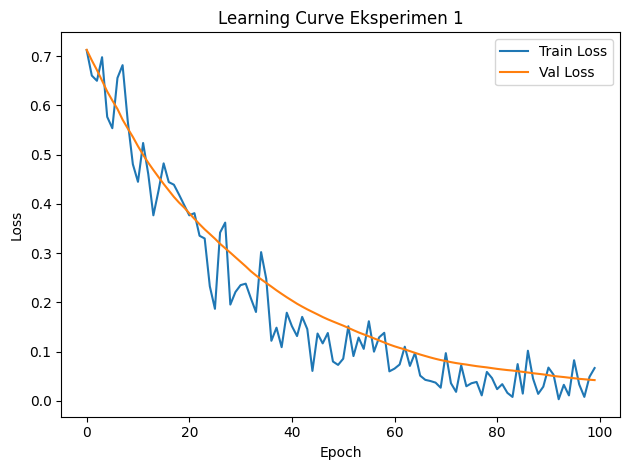

Learning curve disimpan di plots/learning_curve_experiment_1.png

=== Eksperimen 2 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Confusion Matrix:
[[1 0]
 [0 1]]
Classification Report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         1
           1      1.000     1.000     1.000         1

    accuracy                          1.000         2
   macro avg      1.000     1.000     1.000         2
weighted avg      1.000     1.000     1.000         2

F1 Score (macro): 1.0
ROC-AUC: 1.0


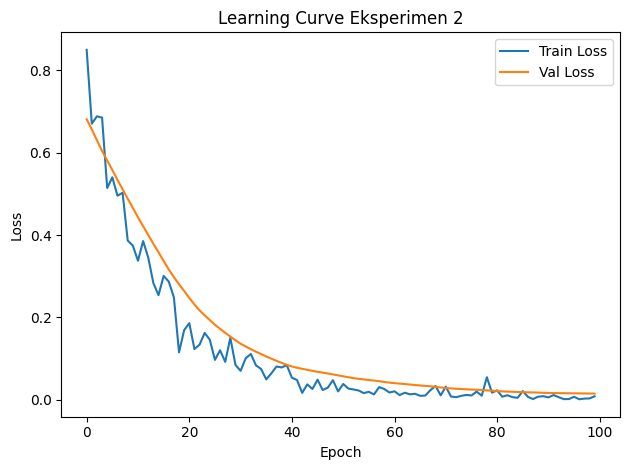

Learning curve disimpan di plots/learning_curve_experiment_2.png

=== Eksperimen 3 ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Confusion Matrix:
[[1 0]
 [0 1]]
Classification Report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         1
           1      1.000     1.000     1.000         1

    accuracy                          1.000         2
   macro avg      1.000     1.000     1.000         2
weighted avg      1.000     1.000     1.000         2

F1 Score (macro): 1.0
ROC-AUC: 1.0


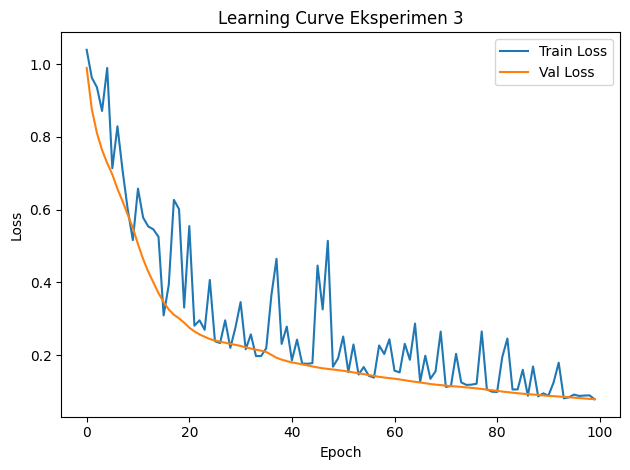

Learning curve disimpan di plots/learning_curve_experiment_3.png


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import os

# ================================
# Seed untuk reproducibility
# ================================
np.random.seed(42)
tf.random.set_seed(42)

# ================================
# Folder untuk simpan plot
# ================================
os.makedirs("plots", exist_ok=True)

# ================================
# Langkah 1 — Load & Siapkan Data
# ================================
df = pd.read_csv("processed_kelulusan.csv")
X = df.drop("Lulus", axis=1)
y = df["Lulus"]

sc = StandardScaler()
Xs = sc.fit_transform(X)

# Split manual aman untuk dataset kecil
if len(df) >= 6:
    n_train = int(0.6 * len(df))
    n_val = int(0.2 * len(df))
    n_test = len(df) - n_train - n_val

    X_train = Xs[:n_train]; y_train = y[:n_train]
    X_val = Xs[n_train:n_train+n_val]; y_val = y[n_train:n_train+n_val]
    X_test = Xs[n_train+n_val:]; y_test = y[n_train+n_val:]
else:
    X_train = Xs; y_train = y
    X_val = Xs; y_val = y
    X_test = Xs; y_test = y

print("Shape dataset:", X_train.shape, X_val.shape, X_test.shape)

def build_ann(neurons=[32,16], dropout=0.3, l2_reg=0.0):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    
    for n in neurons:
        if l2_reg > 0:
            model.add(layers.Dense(n, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg)))
        else:
            model.add(layers.Dense(n, activation="relu"))
        if dropout > 0:
            model.add(layers.Dropout(dropout))
    
    model.add(layers.Dense(1, activation="sigmoid"))
    return model

def train_model(model, optimizer="adam", lr=1e-3, epochs=100, batch_size=1):
    if optimizer.lower() == "adam":
        opt = keras.optimizers.Adam(learning_rate=lr)
    elif optimizer.lower() == "sgd":
        opt = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    else:
        raise ValueError("Optimizer tidak dikenali")
    
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy","AUC"])
    
    es = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=0
    )
    return model, history

configs = [
    {"neurons":[32,16], "dropout":0.3, "l2":0.0, "optimizer":"adam", "lr":1e-3},
    {"neurons":[64,32], "dropout":0.3, "l2":0.0, "optimizer":"adam", "lr":1e-3},
    {"neurons":[32,16], "dropout":0.5, "l2":0.01, "optimizer":"sgd", "lr":1e-2},
]

for i, cfg in enumerate(configs, 1):
    print(f"\n=== Eksperimen {i} ===")
    model = build_ann(neurons=cfg["neurons"], dropout=cfg["dropout"], l2_reg=cfg["l2"])
    model, history = train_model(model, optimizer=cfg["optimizer"], lr=cfg["lr"])
    
    # Evaluasi
    y_proba = model.predict(X_test).ravel()
    y_pred = (y_proba >= 0.5).astype(int)
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))
    print("F1 Score (macro):", f1_score(y_test, y_pred, average="macro"))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba) if len(np.unique(y_test)) > 1 else "N/A")
    
    # Learning curve
    plt.figure()
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title(f"Learning Curve Eksperimen {i}")
    plt.legend()
    plt.tight_layout()
    plot_path = f"plots/learning_curve_experiment_{i}.png"
    plt.savefig(plot_path, dpi=120)
    plt.show()
    print(f"Learning curve disimpan di {plot_path}")
